> CNN-- CNN 예비학습, CNN 구현 (CPU), CNN 구현 (GPU), BCEWithLogisticLoss

# 강의영상 

> <https://youtube.com/playlist?list=PLQqh36zP38-ymnoeGZPPvaaB35JmhRiTi>

# import 

In [1]:
import torch 
import torchvision
from fastai.vision.all import * 
import time

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

# data 

`-` download data 

In [12]:
path = untar_data(URLs.MNIST)

`-` training set 

In [13]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [14]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [15]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

# CNN 예비학습

## 기존의 MLP 모형 

`-` 교재의 모형 

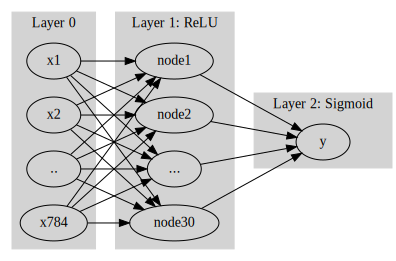

In [4]:
#|code-fold: true
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28 $\times$ 28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 

## 새로운 아키텍처의 제시

`-` 예전

$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$  

- $l_1$: 선형변환, feature를 뻥튀기하는 역할 
- $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화 
- $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를 요약하는 역할) 

`-` 새로운 아키텍처 

- $conv$: feature를 뻥튀기하는 역할 (2d ver $l_1$ 느낌) 
- $relu$: 
- $pooling$: 데이터를 요약하는 역할 

### CONV 레이어 (선형변환의 2D 버전) 

`-` 우선 연산하는 방법만 살펴보자. 

**(예시1)**

In [17]:
torch.manual_seed(43052)
_conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, (2,2) window size
_conv.weight.data, _conv.bias.data

(tensor([[[[-0.1733, -0.4235],
           [ 0.1802,  0.4668]]]]),
 tensor([0.2037]))

In [18]:
_X = torch.arange(0,4).reshape(1,2,2).float()
_X

tensor([[[0., 1.],
         [2., 3.]]])

In [19]:
(-0.1733)*0 + (-0.4235)*1 +\
(0.1802)*2 + (0.4668)*3 + 0.2037

1.541

In [20]:
_conv(_X)

tensor([[[1.5410]]], grad_fn=<SqueezeBackward1>)

**(예시2) 잘하면 평균도 계산하겠다?**

In [21]:
_conv.weight.data = torch.tensor([[[[1/4, 1/4],[1/4,1/4]]]])
_conv.bias.data = torch.tensor([0.0])

In [22]:
_conv(_X) , (0+1+2+3)/4

(tensor([[[1.5000]]], grad_fn=<SqueezeBackward1>), 1.5)

**(예시3) 이동평균?**

In [23]:
_X = torch.arange(0,25).float().reshape(1,5,5) 
_X

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24.]]])

In [24]:
_conv(_X)

tensor([[[ 3.,  4.,  5.,  6.],
         [ 8.,  9., 10., 11.],
         [13., 14., 15., 16.],
         [18., 19., 20., 21.]]], grad_fn=<SqueezeBackward1>)

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [25]:
_conv = torch.nn.Conv2d(1,1,(3,3)) # 입력1, 출력1, (3,3) window size
_conv.bias.data = torch.tensor([0.0])
_conv.weight.data = torch.tensor([[[[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]]])

In [26]:
_X,_conv(_X)

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.0000,  7.0000,  8.0000],
          [11.0000, 12.0000, 13.0000],
          [16.0000, 17.0000, 18.0000]]], grad_fn=<SqueezeBackward1>))

In [27]:
(1+2+3+6+7+8+11+12+13)/9

7.0

**(예시5) 피처뻥튀기**

In [28]:
_X = torch.tensor([1.0,1.0,1.0,1.0]).reshape(1,2,2)
_X

tensor([[[1., 1.],
         [1., 1.]]])

In [29]:
_conv = torch.nn.Conv2d(1,8,(2,2))
_conv.weight.data.shape,_conv.bias.data.shape

(torch.Size([8, 1, 2, 2]), torch.Size([8]))

In [30]:
_conv(_X).reshape(-1)

tensor([-0.3464,  0.2739,  0.1069,  0.6105,  0.0432,  0.8390,  0.2353,  0.2345],
       grad_fn=<ReshapeAliasBackward0>)

In [31]:
torch.sum(_conv.weight.data[0,...])+_conv.bias.data[0],\
torch.sum(_conv.weight.data[1,...])+_conv.bias.data[1]

(tensor(-0.3464), tensor(0.2739))

결국 아래를 계산한다는 의미

In [32]:
torch.sum(_conv.weight.data,axis=(2,3)).reshape(-1)+ _conv.bias.data

tensor([-0.3464,  0.2739,  0.1069,  0.6105,  0.0432,  0.8390,  0.2353,  0.2345])

In [33]:
_conv(_X).reshape(-1)

tensor([-0.3464,  0.2739,  0.1069,  0.6105,  0.0432,  0.8390,  0.2353,  0.2345],
       grad_fn=<ReshapeAliasBackward0>)

***(잔소리) axis 사용 익숙하지 않으면 아래 꼭 들으세요..***

- <https://guebin.github.io/IP2022/2022/04/11/(6주차)-4월11일.html> , numpy공부 4단계: 축

## ReLU (2d)

In [34]:
_X = torch.randn(25).reshape(1,5,5)
_X

tensor([[[ 0.2656,  0.0780,  3.0465,  1.0151, -2.3908],
         [ 0.4749,  1.6519,  1.5454,  1.0376,  0.9291],
         [-0.7858,  0.4190,  2.6057, -0.4022,  0.2092],
         [ 0.9594,  0.6408, -0.0411, -1.0720, -2.0659],
         [-0.0996,  1.1351,  0.9758,  0.4952, -0.5475]]])

In [35]:
a1=torch.nn.ReLU()

In [36]:
a1(_X)

tensor([[[0.2656, 0.0780, 3.0465, 1.0151, 0.0000],
         [0.4749, 1.6519, 1.5454, 1.0376, 0.9291],
         [0.0000, 0.4190, 2.6057, 0.0000, 0.2092],
         [0.9594, 0.6408, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.1351, 0.9758, 0.4952, 0.0000]]])

## Maxpooling 레이어

In [37]:
_maxpooling = torch.nn.MaxPool2d((2,2))

In [38]:
_X = torch.arange(16).float().reshape(1,4,4) 

In [39]:
_X, _maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]),
 tensor([[[ 5.,  7.],
          [13., 15.]]]))

In [40]:
_X = torch.arange(25).float().reshape(1,5,5) 

In [41]:
_X, _maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.,  8.],
          [16., 18.]]]))

In [42]:
_X = torch.arange(36).float().reshape(1,6,6) 

In [43]:
_X, _maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34., 35.]]]),
 tensor([[[ 7.,  9., 11.],
          [19., 21., 23.],
          [31., 33., 35.]]]))

# CNN 구현 (CPU)

In [44]:
X.shape

torch.Size([12665, 1, 28, 28])

## (1) Conv2d

In [45]:
c1 = torch.nn.Conv2d(1,16,(5,5))
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])


## (2) ReLU

In [46]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])


## (3) MaxPool2D

In [47]:
m1 =  torch.nn.MaxPool2d((2,2)) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])


## (4) 적당히 마무리하고 시그모이드 태우자 

`-` 펼치자. 

(방법1)

In [48]:
m1(a1(c1(X))).reshape(-1,2304).shape

torch.Size([12665, 2304])

In [49]:
16*12*12 

2304

(방법2)

In [50]:
flttn = torch.nn.Flatten()

In [51]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])


`-` 2304 $\to$ 1 로 차원축소하는 선형레이어를 설계

In [52]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])


`-` 시그모이드

In [53]:
a2 = torch.nn.Sigmoid()

In [54]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a1(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])


`-` 네트워크 설계

In [55]:
net = torch.nn.Sequential(
    c1, # 2d: 컨볼루션(선형변환), 피처 뻥튀기 
    a1, # 2d: 렐루(비선형변환)
    m1, # 2d: 맥스풀링: 데이터요약
    flttn, # 2d->1d 
    l1, # 1d: 선형변환
    a2 # 1d: 시그모이드(비선형변환) 
)

In [56]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [57]:
t1= time.time()
for epoc in range(100): 
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()
t2= time.time()
t2-t1

51.493837118148804

Text(0.5, 1.0, 'Traning Set')

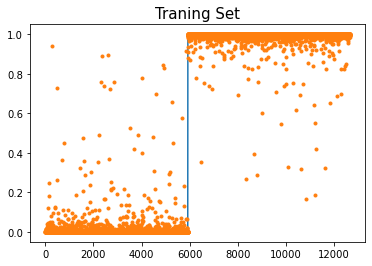

In [58]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

Text(0.5, 1.0, 'Test Set')

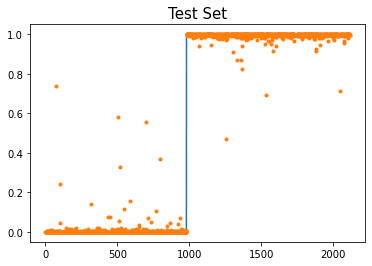

In [59]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

# CNN 구현 (GPU)

## 1. dls

In [60]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [61]:
X.shape

torch.Size([12665, 1, 28, 28])

In [62]:
len(X)/10

1266.5

In [63]:
len(XX)

2115

In [64]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [65]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

## 2. lrnr 생성: 아키텍처, 손실함수, 옵티마이저 

In [66]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()

In [67]:
lrnr = Learner(dls,net,loss_fn)

## 3. 학습

In [68]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,0.904232,0.605049,00:01
1,0.661176,0.371011,00:00
2,0.507179,0.213586,00:00
3,0.392649,0.113123,00:00
4,0.304377,0.065496,00:00
5,0.238253,0.043172,00:00
6,0.188984,0.031475,00:00
7,0.151837,0.024563,00:00
8,0.123364,0.020047,00:00
9,0.101180,0.016816,00:00


## 4. 예측 및 시각화 

In [69]:
net.to("cpu") 

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

`-` 결과를 시각화하면 아래와 같다. 

Text(0.5, 1.0, 'Training Set')

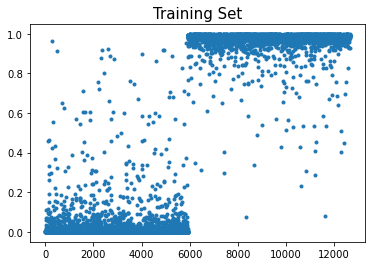

In [70]:
plt.plot(net(X).data,'.')
plt.title("Training Set",size=15)

Text(0.5, 1.0, 'Test Set')

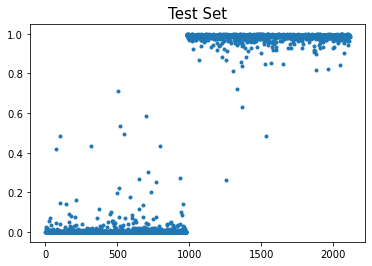

In [71]:
plt.plot(net(XX).data,'.')
plt.title("Test Set",size=15)

`-` 빠르고 적합결과도 좋음 

## Lrnr 오브젝트

In [72]:
lrnr.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [73]:
net

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [74]:
id(lrnr.model), id(net)

(140681387850000, 140681387850000)

In [75]:
lrnr.model(X)

tensor([[5.4047e-03],
        [5.1475e-04],
        [9.8561e-04],
        ...,
        [9.9602e-01],
        [9.9584e-01],
        [9.9655e-01]], grad_fn=<SigmoidBackward0>)

## BCEWithLogitsLoss

`-` BCEWithLogitsLoss = Sigmoid + BCELoss
- 왜 써요? 수치적으로 더 안정 

`-` 사용방법

(1) dls 만들기 

In [76]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [77]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [78]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

(2) lrnr생성 

In [79]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCEWithLogitsLoss()
lrnr = Learner(dls,net,loss_fn) 

(3) 학습

In [80]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,0.896794,0.560268,00:00
1,0.613384,0.301413,00:00
2,0.454223,0.169741,00:00
3,0.346758,0.092166,00:00
4,0.268065,0.056573,00:00
5,0.210524,0.039757,00:00
6,0.167973,0.030431,00:00
7,0.135910,0.024560,00:00
8,0.111290,0.020503,00:00
9,0.092058,0.017516,00:00


(4) 예측 및 시각화

In [81]:
net.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
)

Text(0.5, 0.98, 'Training Set')

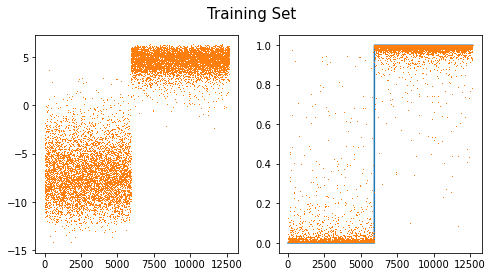

In [82]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(a2(net(X)).data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

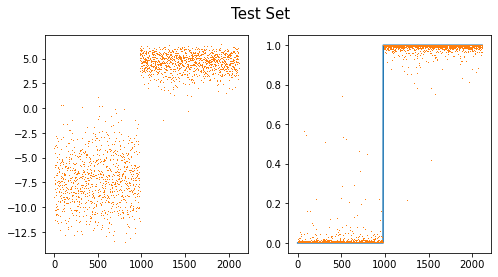

In [83]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(a2(net(XX)).data,',')
fig.suptitle("Test Set",size=15)